<a href="https://colab.research.google.com/github/EnricoMiche1210760/toxic_comments_filter/blob/main/src/progetto_toxic_comments_filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Project: Toxic Comment Filter

The goal of this project is to build a model able to filter user comments based on the degree of harmfulness of the language:
<br>

**1. Preprocess the text by removing the set of tokens that do not provide significant semantic contribution**<br><br>

**2. Transform the text corpus into sequences**<br><br>

**3. Build a Deep Learning model including recurrent layers for a multilabel classification task**<br><br>

**4. In prediction time, the model must return a vector containing a 1 or a 0 corresponding to each label present in the dataset (toxic, severe_toxic, obscene, threat, insult, identity_hate). <br>In this way, a non-harmful comment will be classified by a vector of only 0s [0,0,0,0,0,0]. On the contrary, a dangerous comment will have at least one 1 among the 6 labels.**

In [1]:
import pandas as pd
import numpy as np
import warnings
import tensorflow as tf
import process as pr
import json
import os
from keras.backend import clear_session
import models as md
import pickle
from tensorflow.keras.models import load_model
from models import EarlyStopping, BatchLogger, LSTM_model
import matplotlib.pyplot as plt
import plots as pl

from sklearn.model_selection import train_test_split
from models import weighted_binary_crossentropy

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%config Completer.use_jedi = False
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings("ignore")
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

COLAB = False
if "google.colab" in str(get_ipython()):
    COLAB = True
    print('Running on CoLab')

answer = ""
models_dir = ""
if COLAB:
  models_dir="./models"
else:
  models_dir="../models"

2024-06-20 20:49:47.785924: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-20 20:49:47.807177: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-20 20:49:47.932833: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-20 20:49:47.932931: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-20 20:49:47.957361: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
if COLAB == True:
    BASE_URL = "https://s3.eu-west-3.amazonaws.com/profession.ai/datasets/"
    storage_folder = "./"
else:
    BASE_URL = "../data/"
    storage_folder = BASE_URL
df = pd.read_csv(BASE_URL+"Filter_Toxic_Comments_dataset.csv")

## Dataset
First of all we can analyze the dataset that we have to use for this project. The dataset is composed of 159571 comments and 8 columns. The columns are:
- comment_text: the text of the comment
- toxic: binary label that indicates if the comment is toxic
- severe_toxic: binary label that indicates if the comment is severely toxic
- obscene: binary label that indicates if the comment is obscene
- threat: binary label that indicates if the comment is a threat
- insult: binary label that indicates if the comment is an insult
- identity_hate: binary label that indicates if the comment is an identity hate
- sum_injurious: sum of the labels toxic, severe_toxic, obscene, threat, insult, identity_hate

In [3]:
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0


We can check all the comments that have 2 labels set to 1. 

In [4]:
df[df['sum_injurious']==2]

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious
51,GET FUCKED UP. GET FUCKEEED UP. GOT A DRINK T...,1,0,1,0,0,0,2
58,My Band Page's deletion. You thought I was gon...,1,0,1,0,0,0,2
79,Hi! I am back again!\nLast warning!\nStop undo...,1,0,0,1,0,0,2
86,"Would you both shut up, you don't run wikipedi...",1,0,0,0,1,0,2
168,"You should be fired, you're a moronic wimp who...",1,0,0,0,1,0,2
...,...,...,...,...,...,...,...,...
159253,what do you mean \n\nwhy don't you keep your n...,1,0,1,0,0,0,2
159334,"Horse's ass \n\nSeriously, dude, what's that h...",1,0,1,0,0,0,2
159449,I think he is a gay fag!!!,1,0,0,0,0,1,2
159514,YOU ARE A MISCHIEVIOUS PUBIC HAIR,1,0,0,0,1,0,2


In [5]:
len(df)

159571

### Dataset preprocessing
The dataset is already clean, so we can start with the preprocessing of the text. We decided to remove the set of tokens that do not provide significant semantic contribution, plus the stopwords and the punctuation.
To remove stopwords and punctuation we use the library nltk, while to remove the set of tokens that do not provide significant semantic contribution we use the library spacy, loading the model 'en_core_web_sm'.
Since the corpus is very large, we also decided to remove words smaller than 3 characters. Finally the text is lemmatized and converted to lowercase.

In [6]:
df_text = np.array(df['comment_text'])
type(df_text)

nlp, eng_stopwords = pr.load_dictionary('en_core_web_sm', 'english', 'punkt', stopword=True)
preprocessed_text= pr.preprocess_text_and_store(df_text, doc_store="preprocessed_text.csv", path=storage_folder, 
                                                store=True, eng_stopwords=eng_stopwords, nlp=nlp, word_min_len=3, COLAB=COLAB)


numpy.ndarray

Comparing the original text with the preprocessed text we can see that the text is more readable and the information is more focused on the content of the comment. Moreover the text becomes more compact, reducing the size of the dataset.

In [7]:
df_text[0]
preprocessed_text[0]
len(df_text[0])
len(preprocessed_text[0])


"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

'explanation edits made username hardcore metallica fan reverted vandalisms closure gas voted new york dolls fac please remove template talk page since retired'

264

158

### Dataset brief statistics

Once we preprocess the dataset comments, we can analyze some statistics about the dataset. We can notice that there is all the combination of labels in the dataset, meaning that there is at least one comment:
- with all the labels set to 1
- with all the labels set to 0
- with only one label set to 1 (for each label)
- with two labels set to 1
- with three labels set to 1
- with four labels set to 1
- with five labels set to 1

<br>
We can also notice that the dataset is unbalanced, since the number of comments with all the labels set to 0 is much higher than the number of comments with at least one label set to 1. This is a common problem in multilabel classification tasks, and we will have to deal with it during the training of the model.
The unbalance is also visible in the distribution of the labels, where we can see that the label 'toxic' is the most frequent, while the label 'threat' is the least frequent.

In [8]:
df = df.drop(columns=['comment_text'])
df.head(5)
df['sum_injurious'].unique()


,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0


array([0, 4, 1, 3, 2, 5, 6])

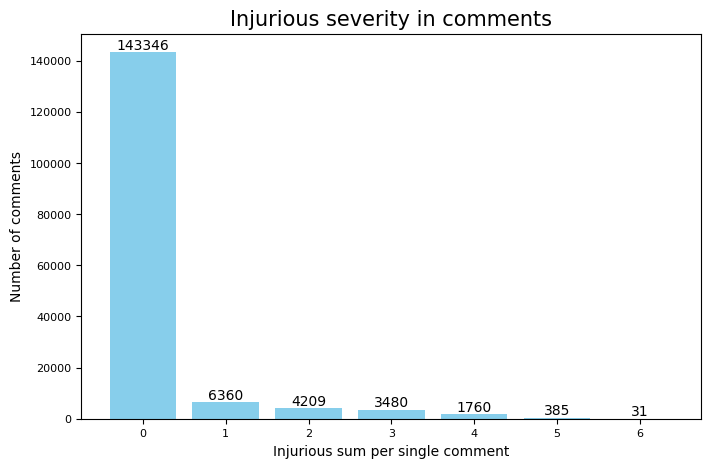

In [9]:
col_names = np.sort(df['sum_injurious'].unique())
comments_per_injurious = df['sum_injurious'].value_counts()

pl.plot_bar(col_names, comments_per_injurious, title='Injurious severity in comments', \
         xlabel='Injurious sum per single comment', ylabel='Number of comments', color='skyblue', \
            xticks_settings={'fontsize':8}, yticks_settings={'fontsize':8})

In [10]:
injurious = df.drop(columns=['sum_injurious'])
non_injurious = pd.Series(data=comments_per_injurious[0], index=["none"])
injurious_type_sum = pd.concat([injurious.sum(axis=0), non_injurious]).sort_values(ascending=False)
injurious_type_sum

none             143346
toxic             15294
obscene            8449
insult             7877
severe_toxic       1595
identity_hate      1405
threat              478
dtype: int64

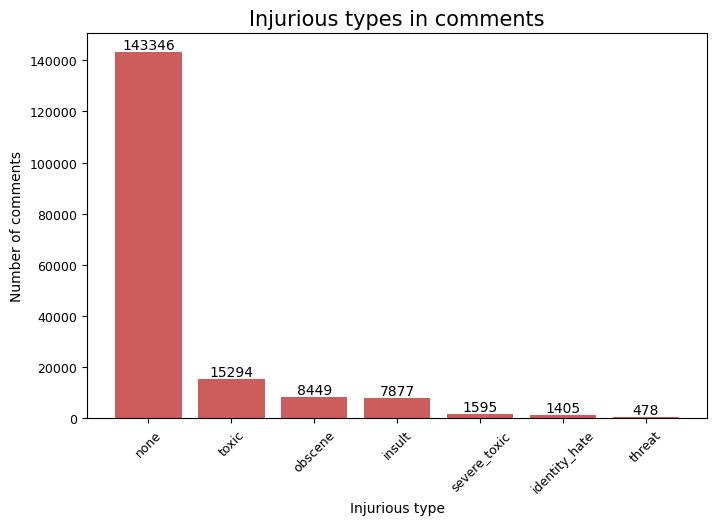

In [11]:
pl.plot_bar(injurious_type_sum.index, injurious_type_sum, title='Injurious types in comments', \
         xlabel='Injurious type', ylabel='Number of comments', color='indianred', \
            xticks_settings={'rotation':45, 'fontsize':9}, yticks_settings={'fontsize':9})

Observing the distribution behaviour with respect to the length of the comments, we can see that the distribution is similar for all the labels, with a median that oscillates between 57 and 71 words. The distribution is right-skewed, with a long tail of comments with a length greater than 1000 words.<br>
Moreover we can observe that for *severe_toxic* comments, we can notice that the 95-percentile is around 2036 words, while for the othes labels the 95-percentile is around 500 words.

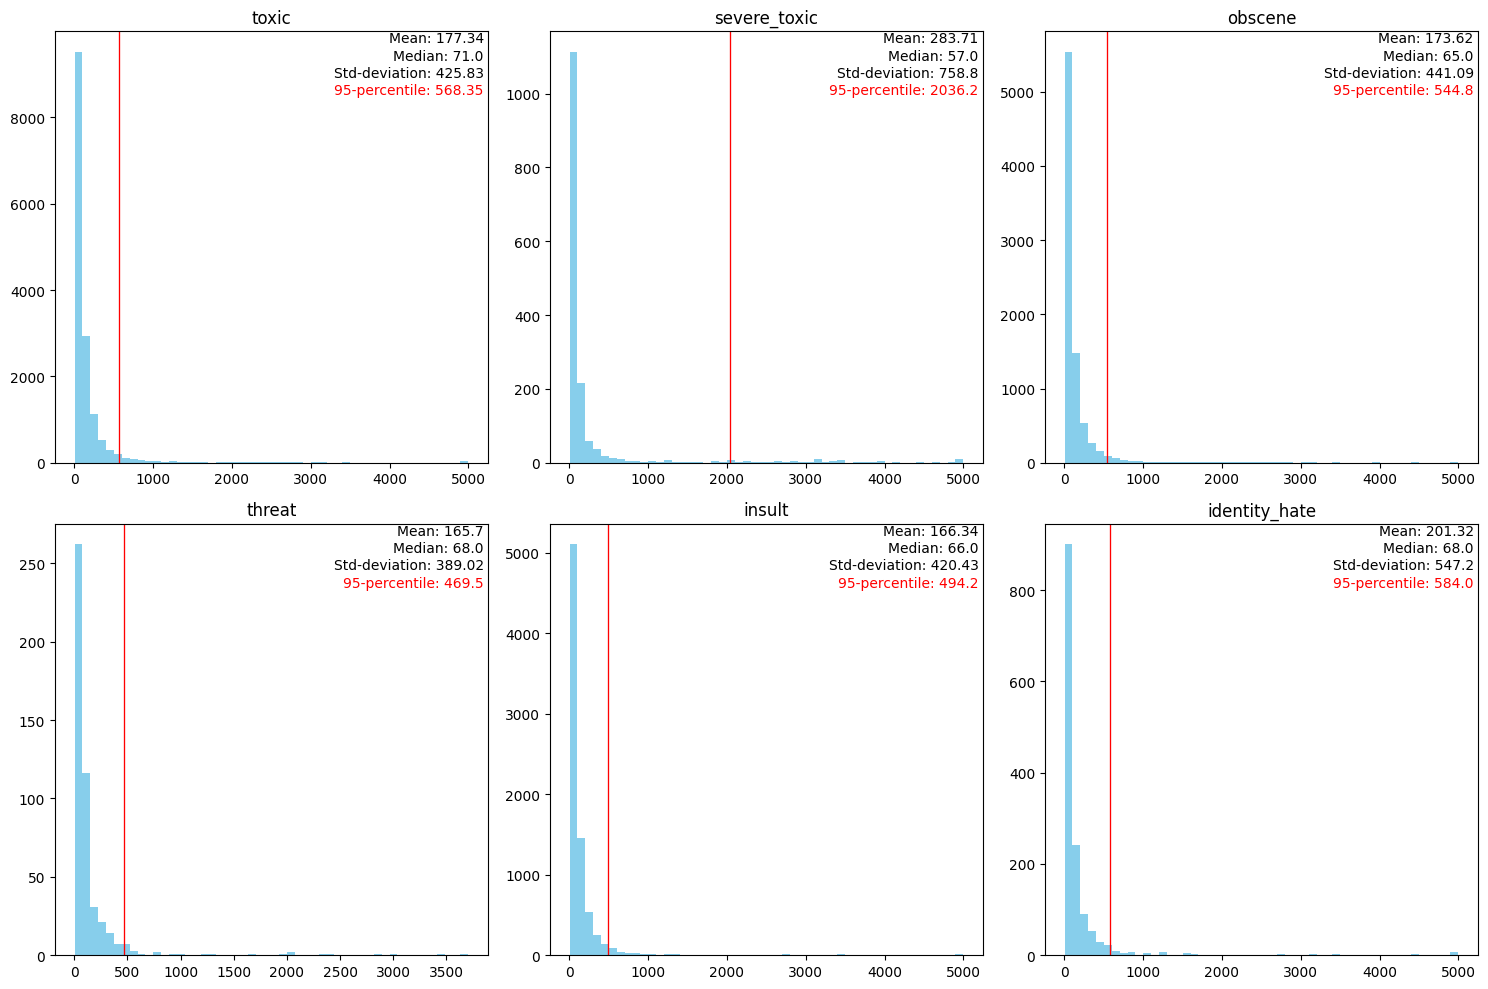

In [12]:
pl.plot_stats(dataframe=df, categories=injurious.columns, data=preprocessed_text)

In [13]:
injurious[0:10]

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
5,0,0,0,0,0,0
6,1,1,1,0,1,0
7,0,0,0,0,0,0
8,0,0,0,0,0,0
9,0,0,0,0,0,0


### Dataset split
We split the dataset into training, validation and test set. For the firsts models we decided to use 40% of the dataset for the training set, 30% for the test set and 30% for the validation set. 
<br><br>We know that the proportion of training, validation and test set (40, 30, 30) is not very usual but, since the dataset is very large and we are limited in hardware resources available, we decided to select a leaner training set in order to be faster during the training phase.

In [14]:
def train_test_val_split(data, labels=None, test_size=0.2, val_size=0.1, random_state=42):
    if labels is None:
        data, labels = data
    corpus, X_test, train_labels, y_test = train_test_split(data, labels, test_size=test_size, random_state=random_state)
    X_train, X_val, y_train, y_val = train_test_split(corpus, train_labels, test_size=val_size/(1-test_size), random_state=random_state)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    y_val = np.array(y_val)

    return X_train.astype(str).tolist(), X_test.astype(str).tolist(), X_val.astype(str).tolist(), y_train, y_test, y_val


In [15]:
X_train, X_test, X_val, y_train, y_test, y_val = train_test_val_split(preprocessed_text, labels=injurious, test_size=0.3, val_size=0.3)


X_train[0:3]
y_train[0:3]

['writing biographies want create biography please first read wp blp follow guidance put front name way removed per guidelines read see wikipedia article wizard advises bit editing first',
 'asking already initiated another sock puppet investigation please wait verdict way proves wp hound orchestrated total attack wiki personality purpose eliminating wiki opinion latest dispute article albania alexikoua remove sourced consensual material cia world fact book official housing census united nations confirm already proven rows wp meat alexikoua addition noticed unethical act user alexikoua forward admin opinion comment removed talk page demonstrated purpose changing artificially established consensus denied alexikoua know yet wiki definition sure get trying say days block verdict account',
 'ok checked pome indeed right legend fate amrod telufinwë one burned ships amras pityafinwë ambarussa survived presumably still died third kinslaying follow pome strictly curufin fëanor fourth son caran

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [16]:
X_train, X_val, X_test, vocab_size, maxlen = pr.get_sequences(X_train, X_val, X_test, num_words=1000)

X_train.shape
y_train.shape

Words number: OrderedDict([('writing', 933), ('biographies', 331), ('want', 4648), ('create', 1096), ('biography', 296), ('please', 11964), ('first', 4370), ('read', 3263), ('wp', 4143), ('blp', 282), ('follow', 639), ('guidance', 86), ('put', 2474), ('front', 283), ('name', 4426), ('way', 4442), ('removed', 2632), ('per', 977), ('guidelines', 1313), ('see', 8559), ('wikipedia', 17657), ('article', 22694), ('wizard', 139), ('advises', 9), ('bit', 1316), ('editing', 3873), ('asking', 486), ('already', 2164), ('initiated', 47), ('another', 2622), ('sock', 477), ('puppet', 169), ('investigation', 180), ('wait', 455), ('verdict', 29), ('proves', 131), ('hound', 17), ('orchestrated', 4), ('total', 380), ('attack', 1172), ('wiki', 2035), ('personality', 96), ('purpose', 425), ('eliminating', 22), ('opinion', 1557), ('latest', 232), ('dispute', 747), ('albania', 68), ('alexikoua', 15), ('remove', 2137), ('sourced', 590), ('consensual', 10), ('material', 1416), ('cia', 85), ('world', 1948), ('

(63828, 1250)

(63828, 6)

## Utility functions and classes
We defined here a couple of utility functions to:
- convert the probability output of the model to a binary output as required;
- search for a model already trained in the folder 'models' and load it if required by the user;
- stretch loss and accuracy values to the same length of the batch loss and validation, in order to plot them together.

<br>
Moreover, from *models.py* we imported the classes **EarlyStopping** and **BatchLogger** that we will use during the training of the model.
These classes are callbacks that we will use to stop the training of the model if the validation loss does not improve for a certain number of epochs and to have a more detailed visualization of the training loss and accuracy respectively.

In [17]:
def build_model(name, model, models_dir, optmizer='adam', loss='binary_crossentropy', metrics=['accuracy']):
  fit = False
  if name in os.listdir(models_dir):
    answer = str(input(f"Found Keras model {name}. Do you want to subscribe it? y/N"))
    if answer.lower() == 'y' or answer == 'yes':
      model.compile(optimizer=optmizer, loss=loss, metrics=metrics)
      fit = True
    elif callable(loss):
      custom_objects = {'loss': loss}
      model = load_model(models_dir+'/'+name, custom_objects=custom_objects)
    else:
      model = load_model(models_dir+'/'+name)
  else:
    print(f"Building {name} model")
    model.compile(optimizer=optmizer, loss=loss, metrics=metrics)
    fit = True
  return model, fit

In [18]:
def convert_probability_to_value(arr:np.array, threshold=.5):
    for i in range(len(arr)):
        for j in range(len(arr[i])):
            arr[i][j] = 1 if arr[i][j] > threshold else 0
    return arr

In [19]:
def stretch_loss_accuracy(val_loss_per_epoch, val_accuracy_per_epoch, batch_log):
    stretch_loss = []
    stretch_accuracy = []

    for i in range(len(val_loss_per_epoch)):
        stretch_loss += [val_loss_per_epoch[i]]*int(len(batch_log.batch_loss) / len(val_loss_per_epoch))
        stretch_accuracy += [val_accuracy_per_epoch[i]]*int(len(batch_log.batch_accuracy) / len(val_accuracy_per_epoch))

    stretch_loss = np.array(stretch_loss)
    stretch_accuracy = np.array(stretch_accuracy)
    return stretch_loss, stretch_accuracy

In [20]:
early_stopping = EarlyStopping()
batch_log = BatchLogger()

## Model 1: LSTM
We built a first model using LSTM layers. LSTM layers are a type of recurrent neural network that are able to learn long-term dependencies in the data. We decided to use this type of layer because the comments are sequences of words and the order of the words is important to understand the meaning of the comment.
The model is composed of:
<br>

- an **Embedding** layer with an input dimension equal to the size of the vocabulary and an output dimension equal to 150
<br>

- a **Dropout** layer with a rate of 0.65 in order to avoid overfitting
<br>

- an **LSTM** layer with 150 units and the return_sequences parameter set to True
<br>

- a **GlobalMaxPooling1D** layer to reduce the dimensionality of the output of the LSTM layer
<br>

- another **Dropout** layer with a rate of 0.35
<br>

- a **Dense** layer with 6 units and Sigmoid activation function.
<br>

The model is compiled using the Adam optimizer and the binary crossentropy loss function. We decided to use the binary crossentropy loss function because we have a multilabel classification task and the labels are binary.

In [123]:
clear_session()

lstm_model_history="base_LSTM.pkl"
lstm_model_name = "LSTM_model.keras"
fit = False

lstm_model = LSTM_model(vocab_size, maxlen, dense_units=len(y_train[0]), activation='sigmoid')

lstm_model, fit = build_model(
   lstm_model_name,
   lstm_model,
   models_dir,
   optmizer='adam',
   loss='binary_crossentropy',
   metrics=['accuracy']
)

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1250, 150)         13954350  
                                                                 
 dropout (Dropout)           (None, 1250, 150)         0         
                                                                 
 lstm (LSTM)                 (None, 1250, 50)          40200     
                                                                 
 global_max_pooling1d (Glob  (None, 50)                0         
 alMaxPooling1D)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 6)                 306       
                                                        

In [124]:
if fit:
    lstm_history = lstm_model.fit(X_train, y_train,
                        epochs=10, batch_size=32,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping, batch_log])    
    pickle.dump(lstm_history, open(storage_folder+"/"+lstm_model_history, 'wb'))
    pickle.dump(batch_log, open(storage_folder+"/lstm_batch_log.pkl", 'wb'))
    if COLAB:
        lstm_model.save("./models/"+lstm_model_name)
    else:
        lstm_model.save("../models/"+lstm_model_name)
else:
    lstm_history = pickle.load(open(storage_folder+"/"+lstm_model_history, 'rb'))
    batch_log = pickle.load(open(storage_folder+"/lstm_batch_log.pkl", 'rb'))



In [125]:
lstm_history.history

{'loss': [0.14665022492408752,
  0.09255949407815933,
  0.07610777020454407,
  0.07273226976394653,
  0.07089883089065552],
 'accuracy': [0.8185436129570007,
  0.9886569976806641,
  0.9944695234298706,
  0.9945164918899536,
  0.9944851994514465],
 'val_loss': [0.11808133870363235,
  0.07356411963701248,
  0.06966039538383484,
  0.06978040188550949,
  0.06821957230567932],
 'val_accuracy': [0.9937331676483154,
  0.9937958121299744,
  0.9938167333602905,
  0.9938167333602905,
  0.9938167333602905]}

In [126]:
y_pred = convert_probability_to_value(lstm_model.predict(X_test))

1496/1496 [==============================] - 244s 163ms/step


Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')


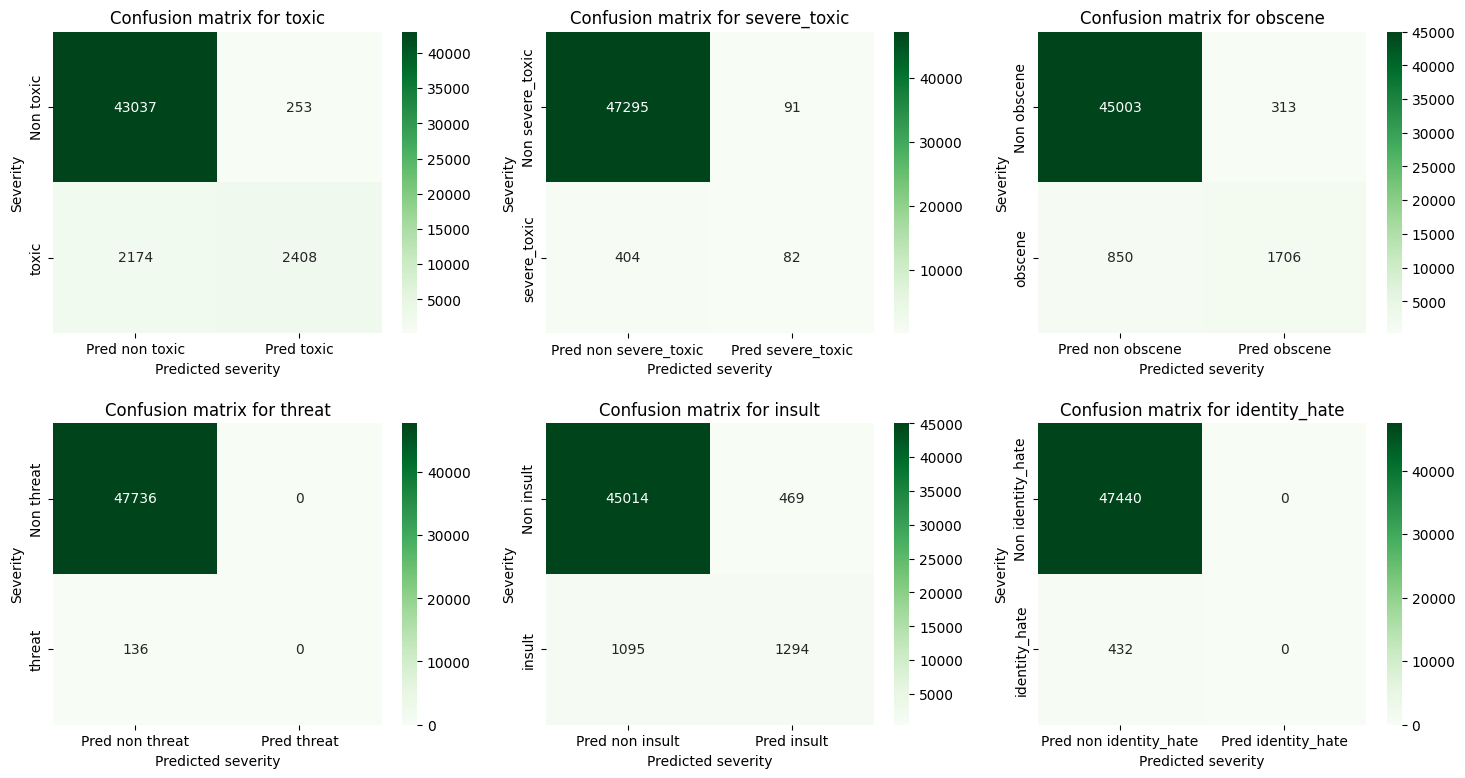

In [127]:
pl.print_confusion_matrix(y_test, y_pred, injurious.columns)

In [128]:
val_loss_per_epoch = lstm_history.history['val_loss']
val_accuracy_per_epoch = lstm_history.history['val_accuracy']
stretch_loss, stretch_accuracy = stretch_loss_accuracy(val_loss_per_epoch, val_accuracy_per_epoch, batch_log)

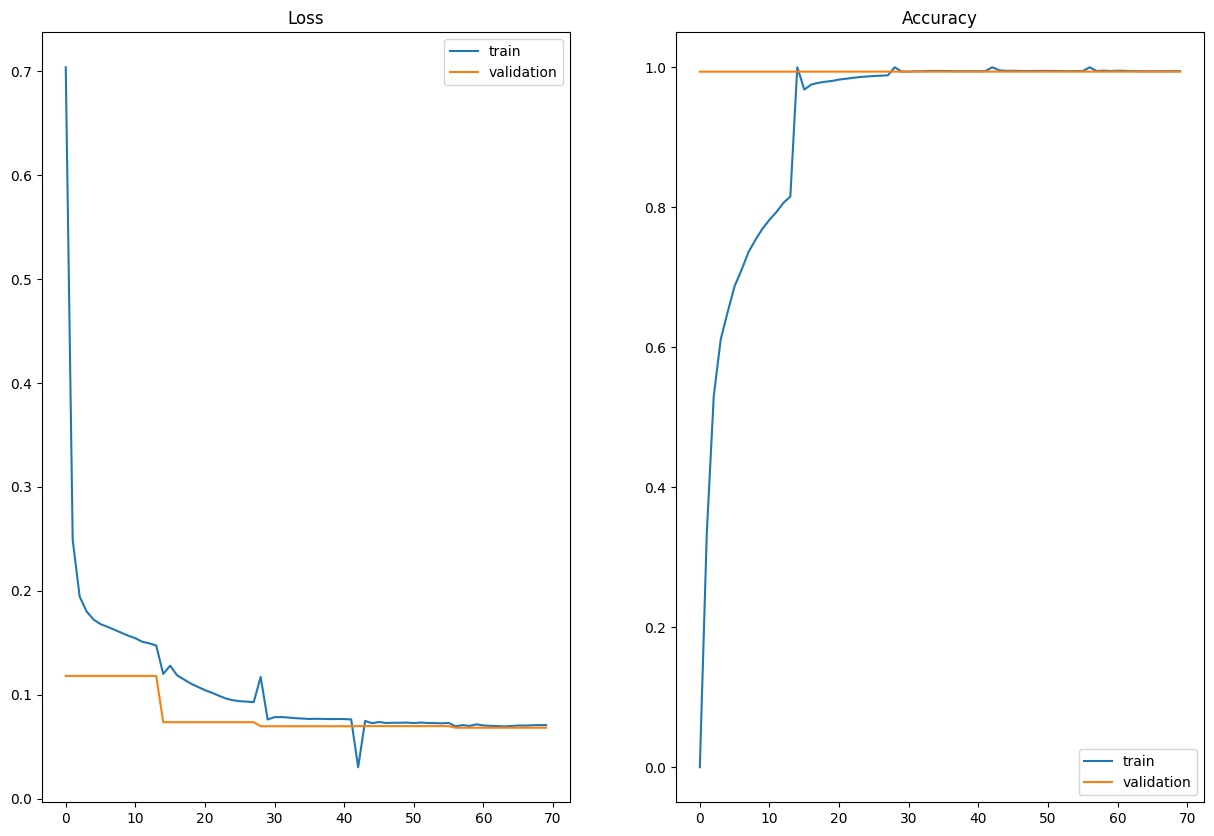

In [129]:
pl.plot_training_stats(batch_log.batch_loss, stretch_loss, batch_log.batch_accuracy, stretch_accuracy)

## Weighted loss function

In [21]:
w0 = [(1/np.sum(y_train.T[i] == 0)) * (len(y_train) /2) for i in range(len(y_train[0]))]
w1 = [(1/np.sum(y_train.T[i] == 1)) * (len(y_train) /2) for i in range(len(y_train[0]))] 
w0, w1

([0.553370786516854,
  0.5051202101897723,
  0.5278618567955142,
  0.5013825174385723,
  0.5258440295925261,
  0.5044096728307255],
 [5.184210526315789,
  49.32612055641422,
  9.472840605520927,
  181.32954545454547,
  10.173414089894804,
  57.193548387096776])

## LSTM model with weighted loss function

In [143]:
clear_session()

lstm_weight_hist_file="LSTM_with_weights.json"
lstm_weight_name = "LSTM_with_weights.keras"
fit = False

lstm_weight = LSTM_model(vocab_size, maxlen, dense_units=len(y_train[0]), activation='sigmoid')

lstm_weight, fit = build_model(
   lstm_weight_name,
   lstm_weight,
   models_dir,
   optmizer='adam',
   loss=weighted_binary_crossentropy(w0, w1),
   metrics=[md.F1Score(), 'accuracy']
)

lstm_weight.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1250, 150)         13954350  
                                                                 
 dropout (Dropout)           (None, 1250, 150)         0         
                                                                 
 lstm (LSTM)                 (None, 1250, 50)          40200     
                                                                 
 global_max_pooling1d (Glob  (None, 50)                0         
 alMaxPooling1D)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 6)                 306       
                                                        

In [144]:
if fit:
    lstm_weight_hist = lstm_weight.fit(X_train, y_train,
                        epochs=10, batch_size=32,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping, batch_log])    
    json.dump(lstm_weight_hist.history, open(storage_folder+"/"+lstm_weight_hist_file, 'w'))
    batch_infos = {'batch_loss':batch_log.batch_loss, 'batch_accuracy':batch_log.batch_accuracy}
    json.dump(batch_infos, open(storage_folder+"/lstm_weight_batch_log.json", 'w'))
    if COLAB:
        lstm_weight.save("./models/"+lstm_weight_name)
    else:
        lstm_weight.save("../models/"+lstm_weight_name)
    lstm_weight_history = lstm_weight_hist.history
else:
    lstm_weight_history = json.load(open(storage_folder+"/"+lstm_weight_hist_file, 'r'))
    batch_infos = json.load(open(storage_folder+"/lstm_weight_batch_log.json", 'r'))
    batch_log.batch_loss = batch_infos['batch_loss']
    batch_log.batch_accuracy = batch_infos['batch_accuracy']


Epoch 1/10
1995/1995 [==============================] - 1355s 678ms/step - loss: 0.5259 - f1_score: 0.0201 - accuracy: 0.8571 - val_loss: 0.1071 - val_f1_score: 0.0000e+00 - val_accuracy: 0.9938
Epoch 2/10
1995/1995 [==============================] - 1324s 664ms/step - loss: 0.1037 - f1_score: 0.0175 - accuracy: 0.9488 - val_loss: 0.0896 - val_f1_score: 5.7268e-04 - val_accuracy: 0.9938
Epoch 3/10
1995/1995 [==============================] - 1282s 642ms/step - loss: 0.0902 - f1_score: 0.1967 - accuracy: 0.9934 - val_loss: 0.0812 - val_f1_score: 0.2448 - val_accuracy: 0.9938
Epoch 4/10
1995/1995 [==============================] - 1236s 619ms/step - loss: 0.0844 - f1_score: 0.2900 - accuracy: 0.9945 - val_loss: 0.0782 - val_f1_score: 0.3490 - val_accuracy: 0.9938
Epoch 5/10
1995/1995 [==============================] - ETA: 0s - loss: 0.0814 - f1_score: 0.3251 - accuracy: 0.9945
Stop training at epoch: 5

1995/1995 [==============================] - 1236s 620ms/step - loss: 0.0814 - f1_sc

1496/1496 [==============================] - 227s 152ms/step
Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')


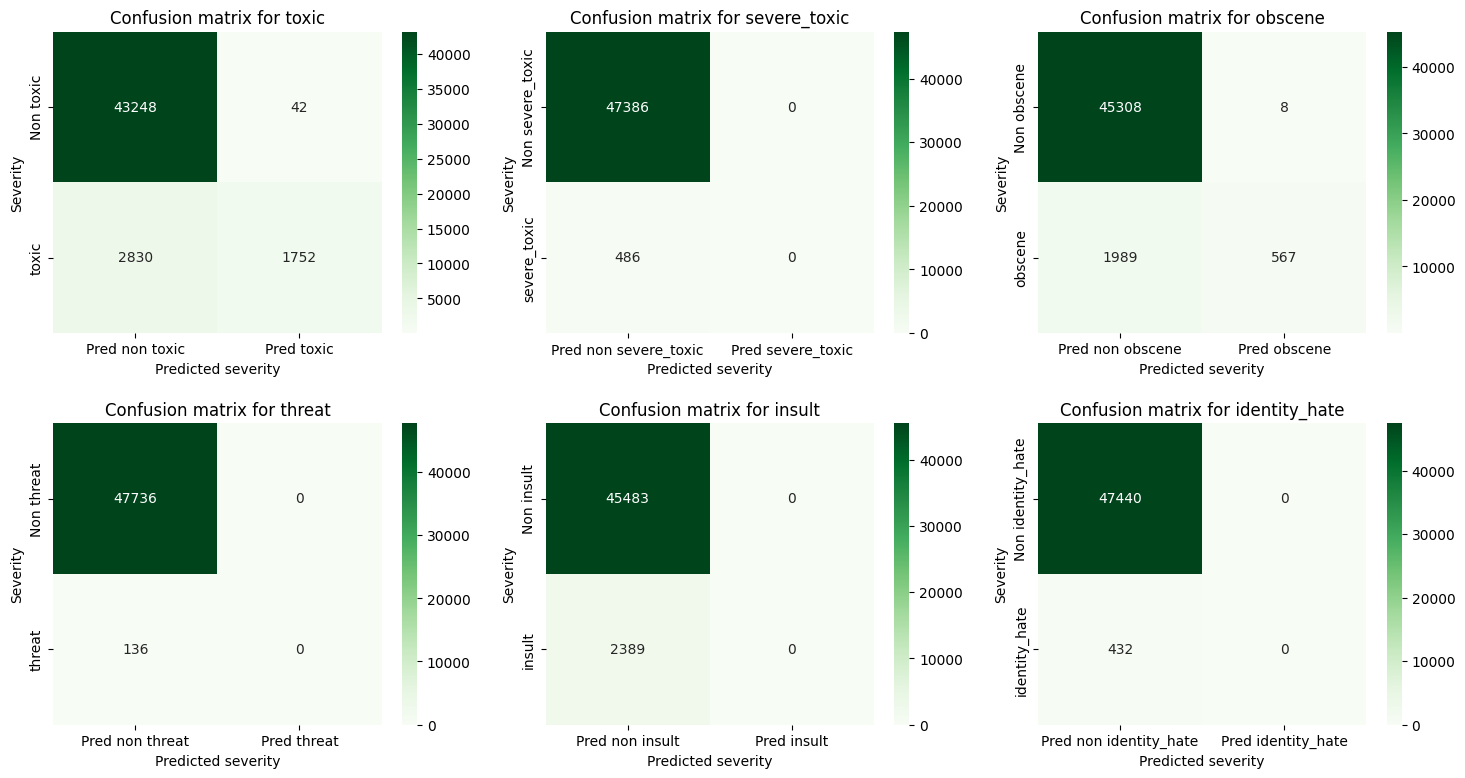

In [145]:
y_pred = convert_probability_to_value(lstm_weight.predict(X_test))
pl.print_confusion_matrix(y_test, y_pred, injurious.columns)

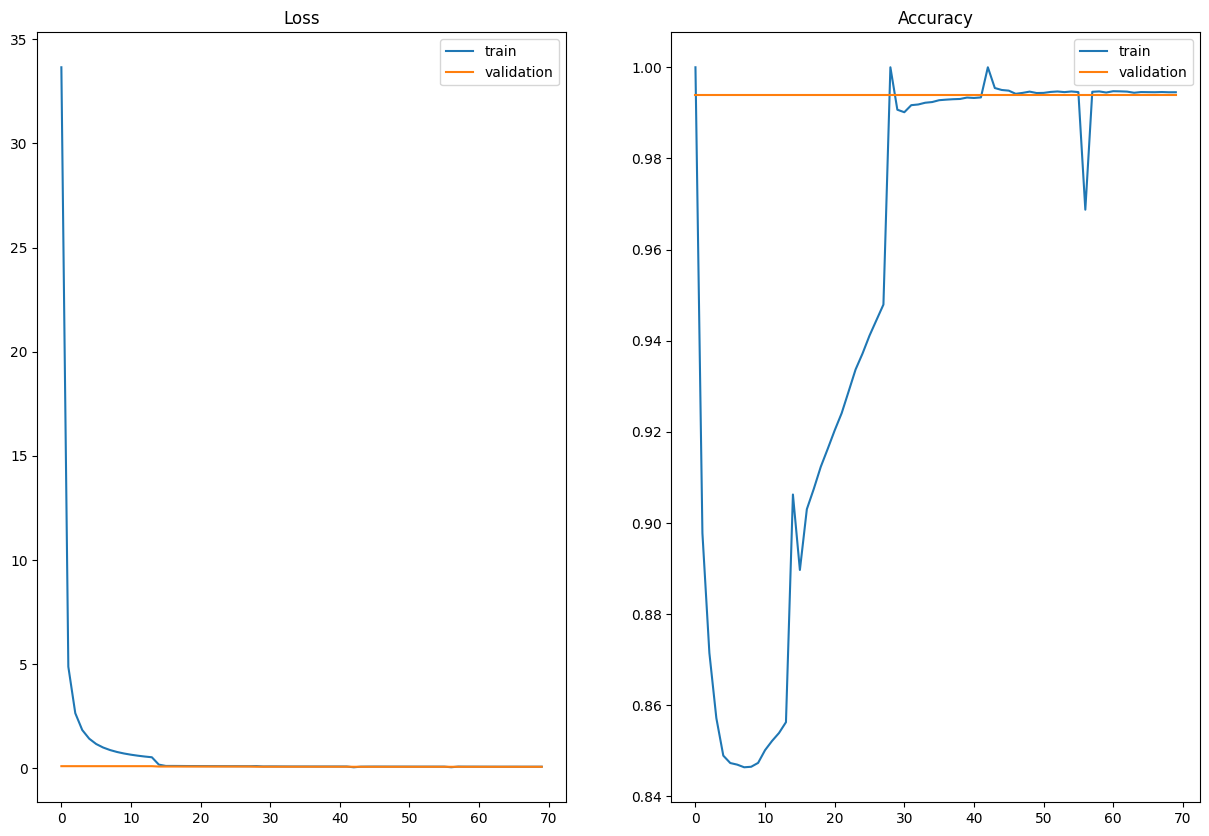

In [146]:
stretch_loss, stretch_accuracy = stretch_loss_accuracy(lstm_weight_history['val_loss'], lstm_weight_history['val_accuracy'], batch_log)
pl.plot_training_stats(batch_log.batch_loss, stretch_loss, batch_log.batch_accuracy, stretch_accuracy)

## RNN with GRU layer

In [22]:
clear_session()
rnn_gru_model_keras = "rnn_gru_model.keras"
rnn_gru_model_history = "history_rnn_gru.pkl"

fit = False

rnn_gru_model = md.GRU_RNN_model(vocab_size, maxlen, dense_units=len(y_train[0]), activation='sigmoid')

rnn_gru_model, fit = build_model(
    rnn_gru_model_keras,
    rnn_gru_model,
    models_dir,
    optmizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

rnn_gru_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1250, 100)         9302900   
                                                                 
 dropout (Dropout)           (None, 1250, 100)         0         
                                                                 
 gru (GRU)                   (None, 1250, 100)         60600     
                                                                 
 dropout_1 (Dropout)         (None, 1250, 100)         0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 50)                7550      
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 32)                1

In [23]:
if fit:
    history_rnn_gru = rnn_gru_model.fit(X_train, y_train,
                        epochs=10, batch_size=32,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping, batch_log])
    pickle.dump(history_rnn_gru, open(storage_folder+"/"+"history_rnn_gru.pkl", 'wb'))
    pickle.dump(batch_log, open(storage_folder+"/rnn_gru_batch_log.pkl", 'wb'))
    rnn_gru_model.save(models_dir+"/rnn_gru_model.keras")

else:
    history_rnn_gru = pickle.load(open(storage_folder+"/"+rnn_gru_model_history, 'rb'))
    batch_log = pickle.load(open(storage_folder+"/rnn_gru_batch_log.pkl", 'rb'))

Epoch 1/10
1995/1995 [==============================] - 2320s 1s/step - loss: 0.1041 - accuracy: 0.8922 - val_loss: 0.0705 - val_accuracy: 0.9938
Epoch 2/10
1995/1995 [==============================] - 2294s 1s/step - loss: 0.0747 - accuracy: 0.9791 - val_loss: 0.0703 - val_accuracy: 0.9938
Epoch 3/10
1995/1995 [==============================] - 2289s 1s/step - loss: 0.0722 - accuracy: 0.9925 - val_loss: 0.0680 - val_accuracy: 0.9938
Epoch 4/10
1995/1995 [==============================] - 2297s 1s/step - loss: 0.0705 - accuracy: 0.9942 - val_loss: 0.0668 - val_accuracy: 0.9938
Epoch 5/10
1995/1995 [==============================] - ETA: 0s - loss: 0.0701 - accuracy: 0.9945
Stop training at epoch: 5

1995/1995 [==============================] - 2300s 1s/step - loss: 0.0701 - accuracy: 0.9945 - val_loss: 0.0678 - val_accuracy: 0.9938


In [24]:
y_pred_rnn_gru = convert_probability_to_value(rnn_gru_model.predict(X_test))

1496/1496 [==============================] - 449s 300ms/step


Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')


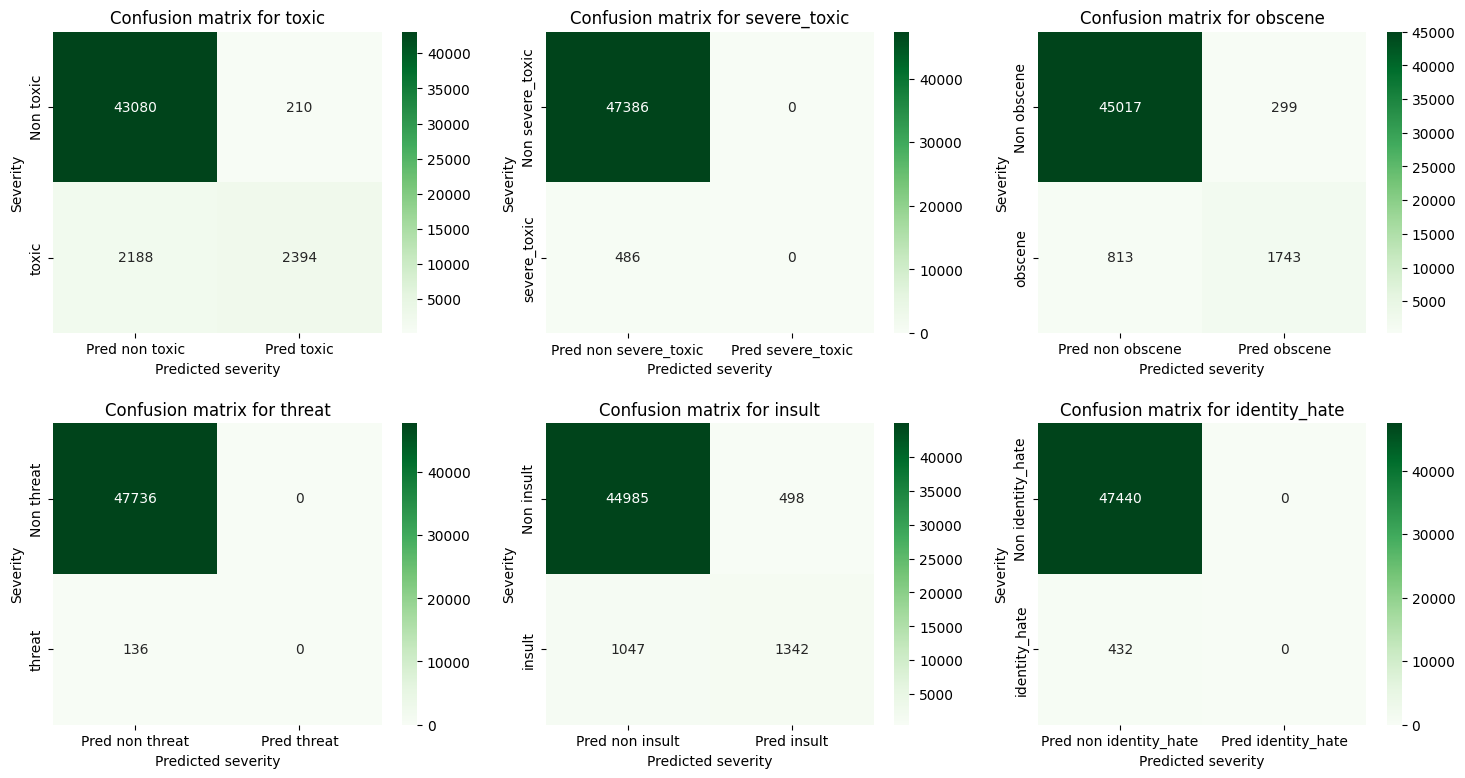

In [25]:
pl.print_confusion_matrix(y_test, y_pred_rnn_gru, injurious.columns)

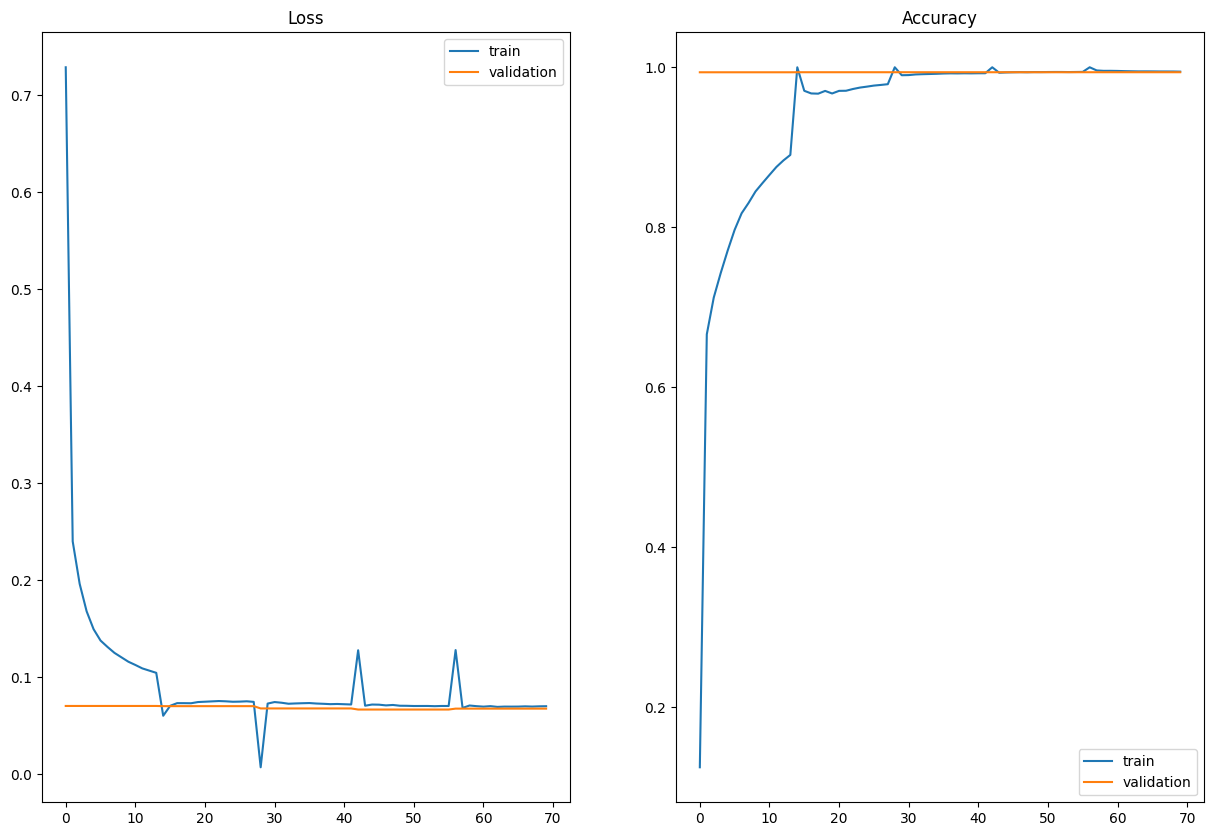

In [28]:
stretch_loss, stretch_accuracy = stretch_loss_accuracy(history_rnn_gru.history['val_loss'], history_rnn_gru.history['val_accuracy'], batch_log)
pl.plot_training_stats(batch_log.batch_loss, stretch_loss, batch_log.batch_accuracy, stretch_accuracy)

## Model with LSTM and Convolutional layer

In [28]:
cnn_model_keras = "cnn_model.keras"
cnn_model_history = "history_cnn.pkl"

if cnn_model_keras in os.listdir(models_dir):
    answer = str(input(f"Found Keras model {cnn_model_keras}. Do you want to subscribe it? y/N"))
    if answer.lower() == 'y' or answer == 'yes':
        clear_session()
        cnn_model = md.CNN_model(vocab_size, maxlen, dense_units=len(y_train[0]), activation='sigmoid')
        cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    else:
        cnn_model = load_model("../models/"+cnn_model_keras)
else:
    cnn_model = md.CNN_model(vocab_size, maxlen, dense_units=len(y_train[0]), activation='sigmoid')

cnn_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1250, 150)         10281900  
                                                                 
 dropout_2 (Dropout)         (None, 1250, 150)         0         
                                                                 
 bidirectional (Bidirection  (None, 1250, 200)         200800    
 al)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 1250, 200)         0         
                                                                 
 conv1d_1 (Conv1D)           (None, 1246, 64)          64064     
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                      

In [29]:
if answer.lower() == 'y' or answer == 'yes':
    history_cnn = cnn_model.fit(X_train, y_train,
                        epochs=10, batch_size=64,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping])

    pickle.dump(history_cnn, open(storage_folder+"/"+cnn_model_history, 'wb'))
    cnn_model.save(models_dir+'/'+cnn_model_keras)   
else:
    history_cnn = pickle.load(open(storage_folder+"/"+cnn_model_history, 'rb'))

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [ ]:
y_pred_cnn = convert_probability_to_value(cnn_model.predict(X_test))
pl.print_confusion_matrix(y_test, y_pred_cnn, injurious.columns)

In [ ]:
y_train.T[5]
range(len(y_train[0]))

In [ ]:
clear_session()
cnn_model_with_w = md.CNN_model(vocab_size, maxlen, dense_units=len(y_train[0]), activation='sigmoid')
cnn_model_with_w.compile(optimizer='adam', loss=weighted_binary_crossentropy(w0, w1), metrics=['f1-score'])
history_cnn_with_w = cnn_model_with_w.fit(X_train, y_train,
                        epochs=10, batch_size=64,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping])

In [ ]:
y_pred_cnn_with_w = convert_probability_to_value(cnn_model_with_w.predict(X_test))
pl.print_confusion_matrix(y_test, y_pred_cnn_with_w, injurious.columns)


## ANOTHER MODEL

In [22]:
X_train, X_test, X_val, y_train, y_test, y_val = train_test_val_split(preprocessed_text, labels=injurious, test_size=0.2, val_size=0.2)


def balance_training_set(X_train, y_train, random_over_sampling=0.5, random_under_sampling=0.5):
    indexes = [[],[],[],[],[],[],[]]
    for i in range(len(y_train)):
        indexes[np.cumsum(y_train[i])[-1]].append(i)
    
    print([sublist[0] for sublist in indexes])
    lenghts = [len(sublist) for sublist in indexes]
    id_class_with_max = lenghts.index(max(lenghts))

    if random_over_sampling > 0:
        for i in range(len(indexes)):
            if i != id_class_with_max:
                list_of_idx_to_add = np.random.choice(indexes[i], int(random_over_sampling*len(indexes[i])), replace=True)
                X_train = np.concatenate((X_train, [X_train[j] for j in list_of_idx_to_add]), axis=0)
                y_train = np.concatenate((y_train, [y_train[j] for j in list_of_idx_to_add]), axis=0)
    
    if random_under_sampling > 0:
        list_of_idx_to_remove = np.random.choice(indexes[id_class_with_max], int(random_under_sampling*len(indexes[id_class_with_max])), replace=False)
        X_train = np.delete(X_train, list_of_idx_to_remove, axis=0)
        y_train = np.delete(y_train, list_of_idx_to_remove, axis=0)

    return X_train, y_train

X_train, y_train = balance_training_set(X_train, y_train, random_over_sampling=0.65, random_under_sampling=0.65)
X_train, X_val, X_test, vocab_size, maxlen = pr.get_sequences(X_train, X_val, X_test, num_words=1500)

X_train.shape, y_train.shape



[0, 15, 17, 45, 116, 35, 3540]
Words number: OrderedDict([('odd', 122), ('stage', 92), ('ever', 1278), ('said', 2011), ('shopping', 25), ('centre', 60), ('management', 62), ('maybe', 1024), ('marketing', 47), ('knows', 293), ('although', 590), ('one', 7191), ('thing', 1393), ('certain', 455), ('far', 953), ('greater', 141), ('powers', 131), ('kept', 177), ('article', 12909), ('link', 1760), ('suggests', 102), ('insignificant', 33), ('dare', 213), ('challenge', 104), ('us', 1709), ('area', 363), ('money', 313), ('talks', 79), ('bullshit', 1198), ('walks', 7), ('bye', 120), ('go', 4299), ('away', 779), ('edit', 4321), ('lesbian', 53), ('topic', 643), ('team', 264), ('watching', 168), ('attempted', 96), ('edits', 2691), ('try', 1225), ('unless', 535), ('want', 3288), ('thrown', 48), ('wikipedia', 11963), ('would', 7311), ('even', 3614), ('think', 5235), ('editing', 2412), ('many', 2336), ('others', 1228), ('tried', 481), ('failed', 192), ('miserably', 5), ('hatnote', 11), ('needed', 463),

((46109, 1250), (46109, 6))

In [23]:
clear_session()

w0 = [(1/np.sum(y_train.T[i] == 0)) * (len(y_train) /2) for i in range(len(y_train[0]))]
w1 = [(1/np.sum(y_train.T[i] == 1)) * (len(y_train) /2) for i in range(len(y_train[0]))] 
w0, w1

cnn_model_2_keras = "cnn_model_2.keras"
cnn_model_2_history = "history_cnn_2.pkl"


if cnn_model_2_keras in os.listdir(models_dir):
    answer = str(input(f"Found Keras model {cnn_model_2_keras}. Do you want to subscribe it? y/N"))
    if answer.lower() == 'y' or answer == 'yes':
        clear_session()
        cnn_model_2 = md.CNN_model_2(vocab_size, maxlen, dense_units=len(y_train[0]), activation='sigmoid')        
        cnn_model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=[md.F1Score(), 'accuracy'])#md.weighted_binary_crossentropy(w0, w1)

    else:
        custom_objects = {'loss': weighted_binary_crossentropy(w0, w1)}
        cnn_model_2 = load_model("../models/"+cnn_model_2_keras, custom_objects=custom_objects)
else:
    clear_session()
    cnn_model_2 = md.CNN_model_2(vocab_size, maxlen, dense_units=len(y_train[0]), activation='sigmoid')        
    cnn_model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=[md.F1Score(), 'accuracy'])#md.weighted_binary_crossentropy(w0, w1)

cnn_model_2.summary()

([0.7435736171585229,
  0.5181135806908331,
  0.6093109918862488,
  0.5057918869704482,
  0.5998152773441565,
  0.51540318794572],
 [1.5263837394067796,
  14.301799007444169,
  2.7870527079303673,
  43.66382575757576,
  3.004626612798123,
  16.730406386066765])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1250, 256)         17547776  
                                                                 
 dropout (Dropout)           (None, 1250, 256)         0         
                                                                 
 conv1d (Conv1D)             (None, 1250, 64)          49216     
                                                                 
 batch_normalization (Batch  (None, 1250, 64)          256       
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 625, 64)           0         
 D)                                                              
                                                                 
 lstm (LSTM)                 (None, 64)                3

In [24]:
answer = "y"
if answer.lower() == 'y' or answer == 'yes':
    history_cnn_2 = cnn_model_2.fit(X_train, y_train,
                        epochs=10, batch_size=64,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping, batch_log])

    pickle.dump(history_cnn_2, open(storage_folder+"/"+cnn_model_2_history, 'wb'))
    cnn_model_2.save(models_dir+'/'+cnn_model_2_keras)   
else:
    history_cnn_2 = pickle.load(open(storage_folder+"/"+cnn_model_2_history, 'rb'))

Epoch 1/10
721/721 [==============================] - 395s 545ms/step - loss: 0.2081 - f1_score: 0.6201 - accuracy: 0.9547 - val_loss: 0.0894 - val_f1_score: 0.6750 - val_accuracy: 0.9940
Epoch 2/10
721/721 [==============================] - 393s 545ms/step - loss: 0.1633 - f1_score: 0.7230 - accuracy: 0.9783 - val_loss: 0.6598 - val_f1_score: 0.1839 - val_accuracy: 0.9933
Epoch 3/10
721/721 [==============================] - 393s 545ms/step - loss: 0.1566 - f1_score: 0.7311 - accuracy: 0.9783 - val_loss: 0.0705 - val_f1_score: 0.6868 - val_accuracy: 0.9940
Epoch 4/10
721/721 [==============================] - 393s 545ms/step - loss: 0.1516 - f1_score: 0.7358 - accuracy: 0.9798 - val_loss: 0.0726 - val_f1_score: 0.6911 - val_accuracy: 0.9940
Epoch 5/10
721/721 [==============================] - ETA: 0s - loss: 0.1484 - f1_score: 0.7423 - accuracy: 0.9758
Stop training at epoch: 5

721/721 [==============================] - 393s 545ms/step - loss: 0.1484 - f1_score: 0.7423 - accuracy: 0

In [25]:
history_cnn_2.history

{'loss': [0.20805218815803528,
  0.16325394809246063,
  0.1565617173910141,
  0.1516427993774414,
  0.14842668175697327],
 'f1_score': [0.6200827360153198,
  0.7229635715484619,
  0.7311362028121948,
  0.735780656337738,
  0.7423057556152344],
 'accuracy': [0.9546509385108948,
  0.9782905578613281,
  0.9782905578613281,
  0.9797870516777039,
  0.975753128528595],
 'val_loss': [0.08938797563314438,
  0.6598266959190369,
  0.07050827890634537,
  0.07258275896310806,
  0.06662332266569138],
 'val_f1_score': [0.6750273108482361,
  0.18394970893859863,
  0.6868228316307068,
  0.6910545825958252,
  0.7007840275764465],
 'val_accuracy': [0.9940465092658997,
  0.9932631254196167,
  0.9940465092658997,
  0.9940465092658997,
  0.9940465092658997]}

998/998 [==============================] - 70s 70ms/step
Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')


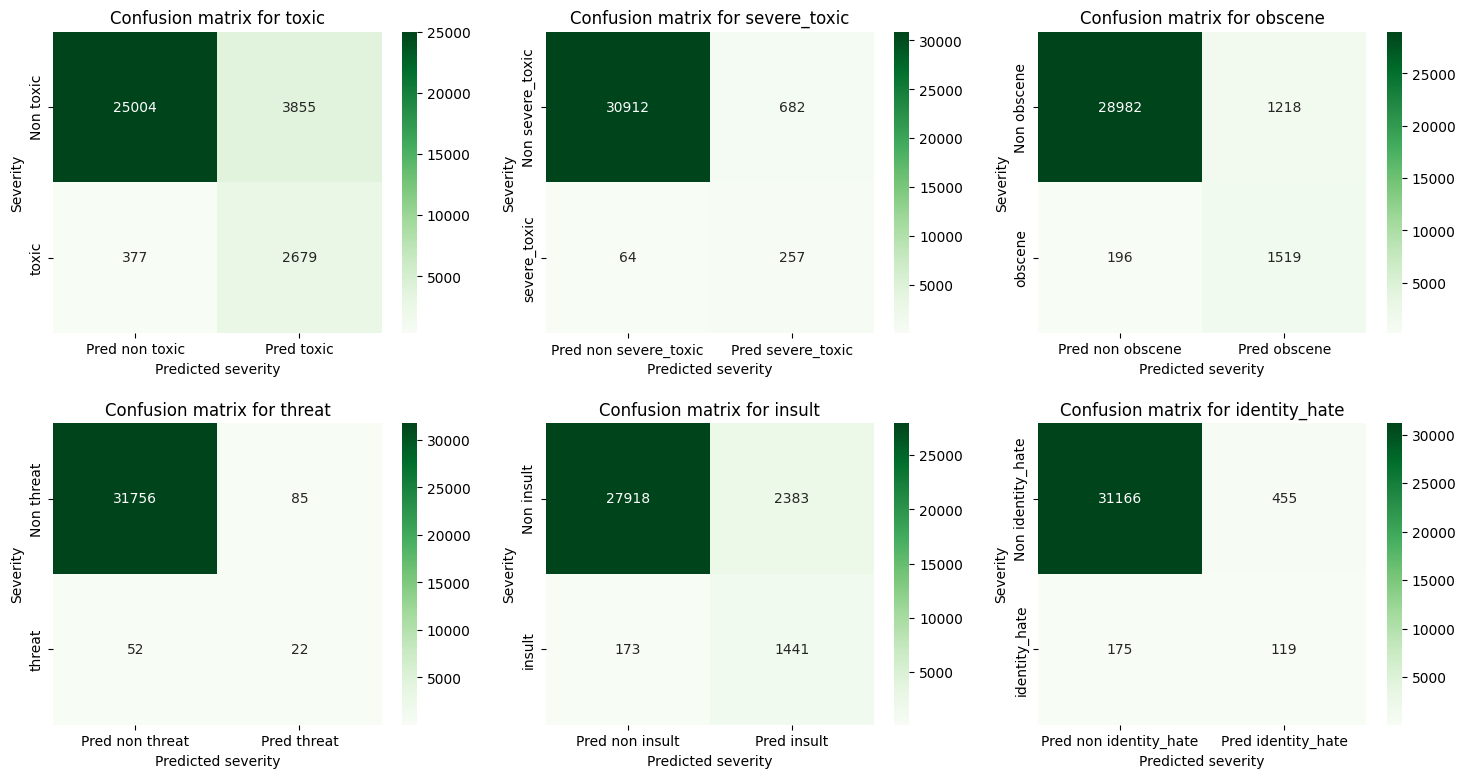

In [26]:
y_pred_cnn_2 = convert_probability_to_value(cnn_model_2.predict(X_test), threshold=.2)
pl.print_confusion_matrix(y_test, y_pred_cnn_2, injurious.columns)

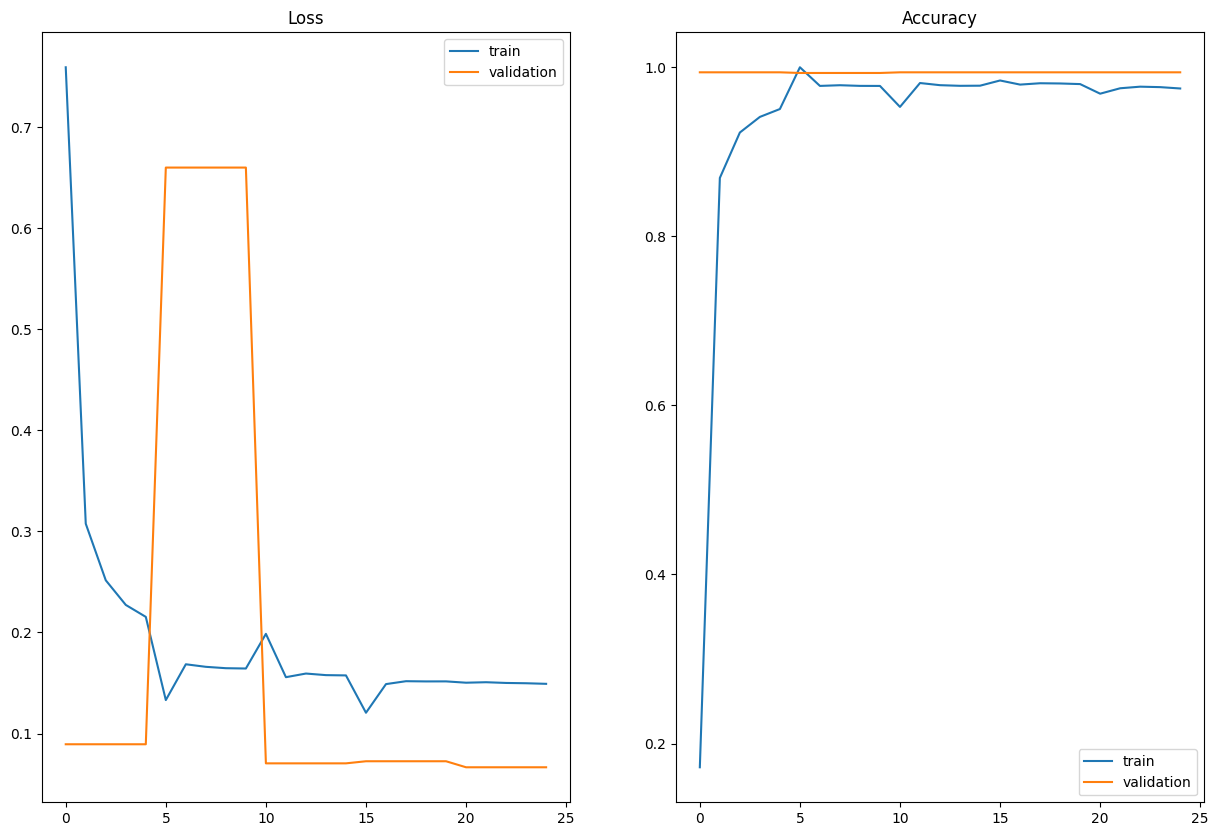

In [27]:
stretch_loss, stretch_accuracy = stretch_loss_accuracy(history_cnn_2.history['val_loss'], history_cnn_2.history['val_accuracy'], batch_log)
pl.plot_training_stats(batch_log.batch_loss, stretch_loss, batch_log.batch_accuracy, stretch_accuracy)